In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [93]:
target_paths = []
target_paths = glob.glob('/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/long_term_forecast_wandb_BAYES_10S_TimesNet_CT2018_ftS_sl24_ll1_pl1_dm44_nh8_el2_dl1_df20_expand2_dc4_fc3_ebtimeF_dtTrue_3s5kt3sq_0')
target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/long_term_forecast_wandb_BAYES_TimesNet_CT2018_ftS_sl28_ll1_pl1_dm48_nh8_el3_dl1_df22_expand2_dc4_fc3_ebtimeF_dtTrue_s2mhzfny_0")
# target_paths = sorted(target_paths, key=lambda x: int(re.search(r'elay(\d+)', x).group(1)))
print(target_paths)
print(len(target_paths))

['/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/long_term_forecast_wandb_BAYES_10S_TimesNet_CT2018_ftS_sl24_ll1_pl1_dm44_nh8_el2_dl1_df20_expand2_dc4_fc3_ebtimeF_dtTrue_3s5kt3sq_0', '/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/long_term_forecast_wandb_BAYES_TimesNet_CT2018_ftS_sl28_ll1_pl1_dm48_nh8_el3_dl1_df22_expand2_dc4_fc3_ebtimeF_dtTrue_s2mhzfny_0']
2


In [7]:
def relative_mean_error(y_true, y_pred):
    print(y_true.__class__)
    print(y_pred.__class__)
    
    return torch.mean(torch.abs(y_true - y_pred) / y_true)
# loss = torch.nn.MSELoss()
def MAE(pred, true):
    return np.mean(np.abs(true - pred))


def MSE(pred, true):
    return np.mean((true - pred) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((true - pred) / true))


def MSPE(pred, true):
    return np.mean(np.square((true - pred) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)

    return mae, mse, rmse, mape, mspe
loss = metric

In [8]:
def concat_data(data,index):
    datas = []
    if data.shape[1] <= 1:
        for i in index:
            temp = data[i,:,:].squeeze(axis = 1)
            datas.append(temp)
            # datas.append(data[i,:,:].squeeze(axis = 1))
        datas = np.array(datas)
        return datas
    else:
        for i in index:
            temp = data[i,:,:].squeeze(axis = 1)
            # print(temp)
            # print("tempshape:",temp.shape)
            # temp = temp.flatten()
            # print(temp)
            datas.append(temp)
            # datas.append(temp)
        # print("datas:",datas)
        print(len(datas))
        # datas = np.array(np.concatenate(datas, axis = 0))
        datas = np.concatenate(datas, axis = 0)
        return datas

In [9]:

def visual_full_scale(  trues,  preds=None,start_index = None,plot_step = None, name='./pic/test.png', mode = 'concate', random = False , sample_num = 5,title = ''):
    """
    Results visualization
    """
    assert mode in ['concate', 'test_consistance', ]
    if plot_step is None:
        plot_step = trues.shape[0]
    if random :
        start_idx = np.random.randint(0, trues.shape[1])
    elif start_index is None:
        start_idx = 0
    else:
        start_idx = start_index
    plt.figure(figsize=(100, 6))
    true_line = []
    pred_line = []
    if mode == 'concate':
        # for index in range(start_idx, plot_step, trues.shape[1]):
        #     # print(trues[index,:,:].shape)
        #     true_line.append(trues[index,:,:].squeeze(axis = 1))
        #     # print(true_line[-1].shape)
        #     if preds is not None:
        #         pred_line.append(preds[index,:,:].squeeze(axis = 1))
        true_line = concat_data(trues, range(start_idx, plot_step, trues.shape[1]))
        if preds is not None:
            pred_line = concat_data(preds, range(start_idx, plot_step, trues.shape[1]))
    elif mode == 'test_consistance':
        random_idx = np.random.randint(0,preds.shape[0])
        for index in range(sample_num):
            plt.plot(preds[random_idx + index, sample_num-index:, :].squeeze(axis = 1), label = f'{index}th line',linewidth=2)
        plt.legend()
        plt.title(title)
        plt.savefig(name, bbox_inches='tight')
        plt.close()
        return
    true_line = np.concatenate(true_line)
    if preds is not None:
        pred_line = np.concatenate(pred_line)
    plt.plot(list(range(start_idx,start_idx+ len(true_line))),true_line, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(list(range(start_idx,start_idx + len(true_line))),pred_line, label='Prediction', linewidth=2)

    plt.legend()
    plt.savefig(name, bbox_inches='tight')
    plt.close()

In [10]:

def visual_full_scale_onestep(  trues,  preds=None,start_index = None,plot_step = None, name='./pic/test.png', mode = 'concate', random = False , sample_num = 5, manual_offset = 0, title = ''):
    """
    Results visualization
    """
    assert mode in ['concate', 'test_consistance', ]
    if plot_step is None:
        plot_step = trues.shape[0]
    if random :
        start_idx = np.random.randint(0, trues.shape[1])
    elif start_index is None:
        start_idx = 0
    else:
        start_idx = start_index
    plt.figure(figsize=(100, 6))
    true_line = []
    pred_line = []
    if mode == 'concate':
        # for index in range(start_idx, plot_step, trues.shape[1]):
        #     # print(trues[index,:,:].shape)
        #     true_line.append(trues[index,:,:].squeeze(axis = 1))
        #     # print(true_line[-1].shape)
        #     if preds is not None:
        #         pred_line.append(preds[index+manual_offset,:,:].squeeze(axis = 1))
        true_line = concat_data(trues, range(start_idx, plot_step, trues.shape[1]))
        if preds is not None:
            pred_line = concat_data(preds, range(start_idx, plot_step, trues.shape[1]))
    elif mode == 'test_consistance':
        random_idx = np.random.randint(0,preds.shape[0])
        for index in range(sample_num):
            plt.plot(preds[random_idx + index, sample_num-index:, :].squeeze(axis = 1), label = f'{index}th line',linewidth=2)
        plt.legend()
        plt.title(title)
        plt.savefig(name, bbox_inches='tight')
        plt.close()
        return
    true_line = np.concatenate(true_line)
    if preds is not None:
        pred_line = np.concatenate(pred_line)
    plt.plot(list(range(start_idx,len(true_line))),true_line, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(list(range(start_idx,len(true_line))),pred_line, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')
    plt.close()


In [11]:
for path in target_paths:
    true_line = np.load(f"{path}/true.npy")
    pred_line = np.load(f"{path}/pred.npy")
    print(true_line.shape)
    print(pred_line.shape)
    visual_full_scale(
        true_line,
        pred_line,
        start_index=300,
        plot_step=500,
        name=f"{path}/plot_300_800.png",
        mode="concate",
        random=True,
        sample_num=5,
    )


(3456, 1, 1)
(3456, 1, 1)


In [12]:
def extract_lookback(path):
    match = re.search(r'elay\d+', path)
    if match:
        return match.group(0)
    return None
def extract_pre(path):
    match = re.search(r'pre\d+', path)
    if match:
        return match.group(0)
    return None
def extrace_elay(path):
    match = re.search(r'elay\d+', path)
    if match:
        return match.group(0)
    return None

In [13]:
for path in target_paths:
    true_line = np.load(f"{path}/true.npy")
    pred_line = np.load(f"{path}/pred.npy")
    print(true_line.shape)
    print(pred_line.shape)

    # lookback_field = extract_lookback(path)
    lookback_field = extract_pre(path)
    if lookback_field:
        title = f"Plot with {lookback_field}"
    else:
        title = "Plot"
    print(title)
    visual_full_scale(
        true_line,
        pred_line,
        start_index=300,
        plot_step=500,
        name=f"{path}/plot_300_800_offset1.png",
        mode="concate",
        random=True,
        sample_num=5,
        # manual_offset = 1,
        title=title,
    )

(3456, 1, 1)
(3456, 1, 1)
Plot


In [38]:
##统计绘图
def plot_loss(trues,preds,labels,loss_fn,axs,title):
    loss_list = []
    # plt.figure(figsize=(20, 6))
    legend_elements = []
    errors = {'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE': [], 'MSPE': []}
    colors = ['b', 'g', 'r', 'c','m']
    # fig, axs = plt.subplots(1, len(trues), figsize=(20, 6))
    for i in range(len(trues)):
        if i == 2:
            continue
        # true_tensor = torch.from_numpy(trues[i])
        # pred_tensor = torch.from_numpy(preds[i])
        plt.figure(figsize = (10,6))
        plt.plot(trues[i][300:400], label='GroundTruth', linewidth=2)
        plt.plot(preds[i][300:400], label='Prediction', linewidth=2)
        plt.plot(preds[i][300:400] - trues[i][300:400], label='Error', linewidth=2)
        plt.title(f"{title},{labels[i]}")
        plt.legend()
        plt.grid()
        # plt.show()
        plt.savefig(f'./plot/{title}_{labels[i]}.png', bbox_inches='tight')
        # 计算损失并添加到列表中
        mae, mse,rmse,mape, mspe = loss_fn(trues[i], preds[i])
        errors['MAE'].append(mae)
        errors['MSE'].append(mse)
        errors['RMSE'].append(rmse)
        errors['MAPE'].append(mape)
        errors['MSPE'].append(mspe)
        print("errors:",errors)
        color = colors[i % len(colors)] 
        # for i, (error_name, error_values) in enumerate(errors.items()):
        #     axs.bar(i, error_values, color=colors[i], label=error_name)
        axs.bar(i, errors['MAPE'][-1], color=color)
        axs.grid()
        # axs.set_yscale('log')
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'{labels[i]}'))
        # legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'Sample {i+1}'))
        # axs.legend()
    axs.set_title(f"{title}") 
    # axs.legend(handles=legend_elements, loc='upper left')
    # 设置整体标题
    # fig.suptitle('Loss for Each Sample')
    # plt.show()


In [15]:
def average_movement(trues,lookback_len):
    window = np.ones(lookback_len)/lookback_len
    return np.convolve(trues.squeeze(), window, mode='valid')

In [ ]:
#测试移动平均值函数
true_line = np.load(f"{target_paths[0]}/true.npy")
pred_line = np.load(f"{target_paths[0]}/pred.npy")
print(true_line.shape)
print(pred_line.shape)
lookback_len = 3
average_line = average_movement(true_line,lookback_len)
plt.plot(average_line[300:800])
plt.plot(true_line.squeeze()[300:800])
plt.show()


In [61]:
def ARIMA_predict(data, order=(5,1,0)):
    model = ARIMA(data, order)
    output = model.fit()
    # output = model_fit.forecast()
    return output

In [ ]:
def AR_predict(data, lags=1):
    model = AutoReg(data, lags)
    model_fit = model.fit()
    output = model_fit.predict()
    return output

[3739983.25 4358530.75 4291504.75 ... 4212826.5  5366904.75 6258259.75]
(24192,)
(20736,)
(3456,)
[ 1.50808179e+05  1.41189772e+00 -5.14055922e-01  1.25707301e-01
 -5.95326266e-02  3.78540190e-02 -2.44530635e-02  9.52909767e-03
  1.65276795e-03 -3.60697263e-02  3.53543961e-02]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                20736
Model:                    AutoReg(10)   Log Likelihood             -319318.396
Method:               Conditional MLE   S.D. of innovations        1187926.116
Date:                Wed, 06 Nov 2024   AIC                         638660.792
Time:                        14:58:57   BIC                         638756.062
Sample:                            10   HQIC                        638691.908
                                20736                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

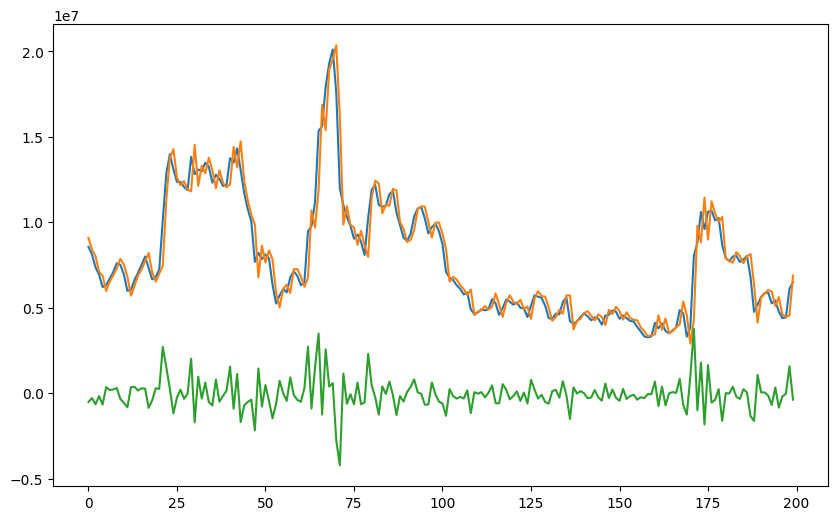

In [92]:
true_line = np.load(f"{path}/true.npy")
pre_number = 1
true_line = concat_data(true_line, range(0, true_line.shape[0], pre_number))
df = pd.read_csv("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/dataset/cluster_trace_2018/statisticsByCoreTimePreFrame/dataSampleFrame25s/statisiticByCoreTimePreFrame/task_type1_CTPF_8640_6912_date.csv")
np_data = df["count"].to_numpy()
print(np_data)
print(np_data.shape)
train_data = np_data[0:len(np_data)//7*6]
test_data = np_data[len(np_data)//7*6:]
print(train_data.shape)
print(test_data.shape)
lags = 10
ar_fit = AutoReg(train_data, lags).fit()
print(ar_fit.params)
print(ar_fit.summary())
pred_list = []
# arima_fit = ARIMA(train_data, order=(5,1,2)).fit()
# print(arima_fit.summary())
# 假设 true_line 是你的时间序列数据
for i in range(len(test_data[lags:])):
    history = test_data[i:i+lags]
    yhat = ar_fit.params[0]
    for j in range(1, lags+1):
        yhat += ar_fit.params[j] * history[-j]
    # print(f"Predicted: {yhat}, True: {test_data[i+lags]}")
    pred_list.append(yhat)
plt.figure(figsize=(10, 6))
plt.plot(test_data[lags:][200:400])
plt.plot(pred_list[200:400])
print(metric(np.array(pred_list), test_data[lags:]))
plt.plot(test_data[lags:][200:400]-np.array(pred_list[200:400]))
# # 设置滞后阶数
# lags = 5
# model_fit = AutoReg(true_line, lags).fit()

# print(model_fit.params)
# # 滚动预测每一步的下一步


# 将预测值转换为Series

# # 可视化结果
# plt.figure(figsize=(10, 6))
# plt.plot(true_line, label='原始数据')
# plt.plot(pred_line, label='预测数据', color='red')
# plt.legend()
# plt.show()

(8640, 1, 1)
(8640, 1, 1)
before concate (8640, 1, 1)
after concate (8640, 1)
Plot
range(0, 8640)
pred_line_origin shape: (8640, 1)
true_line shape: (8640, 1)
errors: {'MAE': [162694.86], 'MSE': [78175584000.0], 'RMSE': [279598.97], 'MAPE': [0.03737133], 'MSPE': [0.0035967]}
errors: {'MAE': [162694.86, 95514.98], 'MSE': [78175584000.0, 22474056000.0], 'RMSE': [279598.97, 149913.5], 'MAPE': [0.03737133, 0.021730883], 'MSPE': [0.0035967, 0.0010988044]}


errors: {'MAE': [162694.86, 95514.98, 155503.48], 'MSE': [78175584000.0, 22474056000.0, 81405220000.0], 'RMSE': [279598.97, 149913.5, 285316.0], 'MAPE': [0.03737133, 0.021730883, 0.03486662], 'MSPE': [0.0035967, 0.0010988044, 0.003572411]}
(3456, 1, 1)
(3456, 1, 1)
before concate (3456, 1, 1)
after concate (3456, 1)
Plot
range(0, 3456)
pred_line_origin shape: (3456, 1)
true_line shape: (3456, 1)
errors: {'MAE': [678423.44], 'MSE': [1104297900000.0], 'RMSE': [1050855.8], 'MAPE': [0.062630355], 'MSPE': [0.009748183]}
errors: {'MAE': [678423.44, 324586.2], 'MSE': [1104297900000.0, 254624460000.0], 'RMSE': [1050855.8, 504603.28], 'MAPE': [0.062630355, 0.028068924], 'MSPE': [0.009748183, 0.0015561227]}
errors: {'MAE': [678423.44, 324586.2, 711684.3], 'MSE': [1104297900000.0, 254624460000.0, 1355758000000.0], 'RMSE': [1050855.8, 504603.28, 1164370.2], 'MAPE': [0.062630355, 0.028068924, 0.06442585], 'MSPE': [0.009748183, 0.0015561227, 0.011338954]}


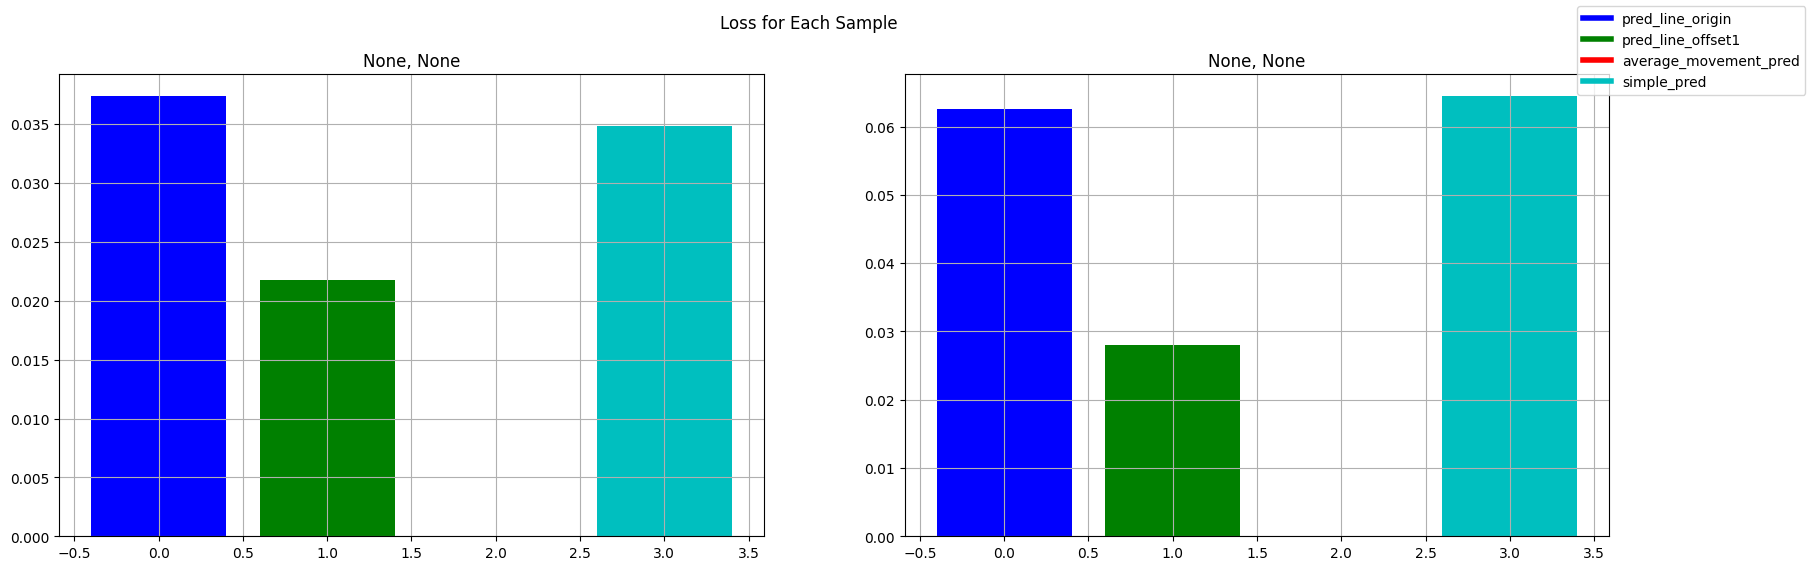

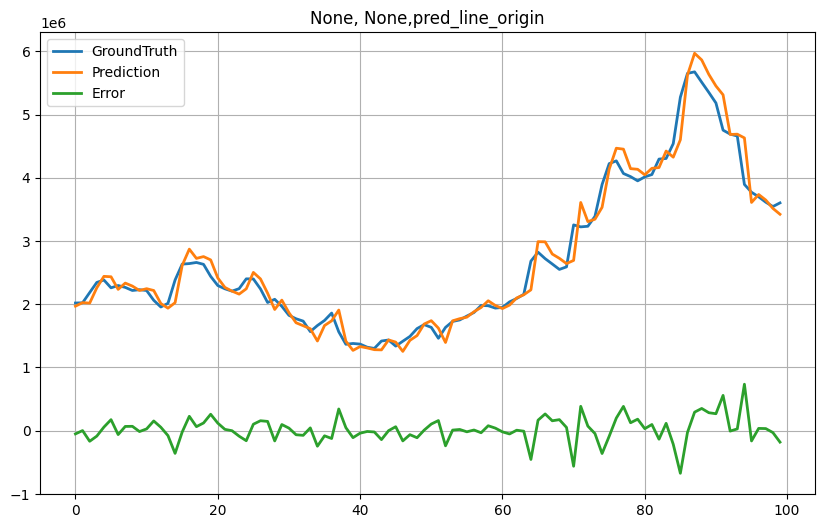

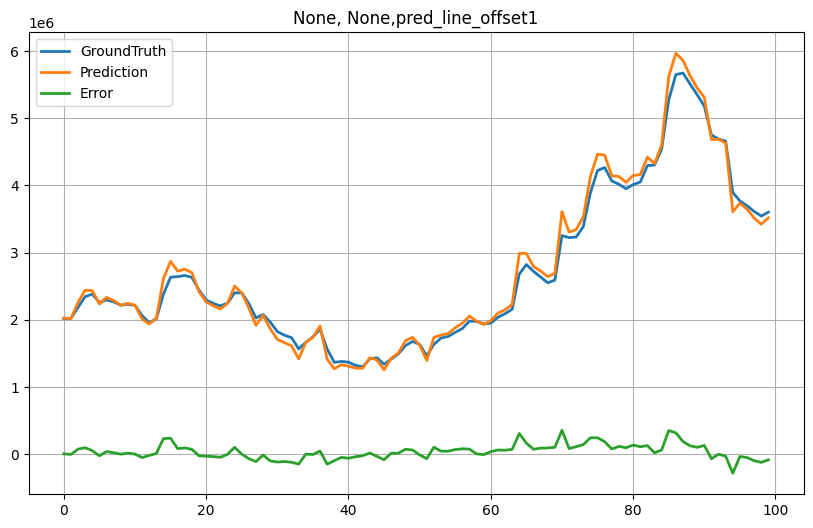

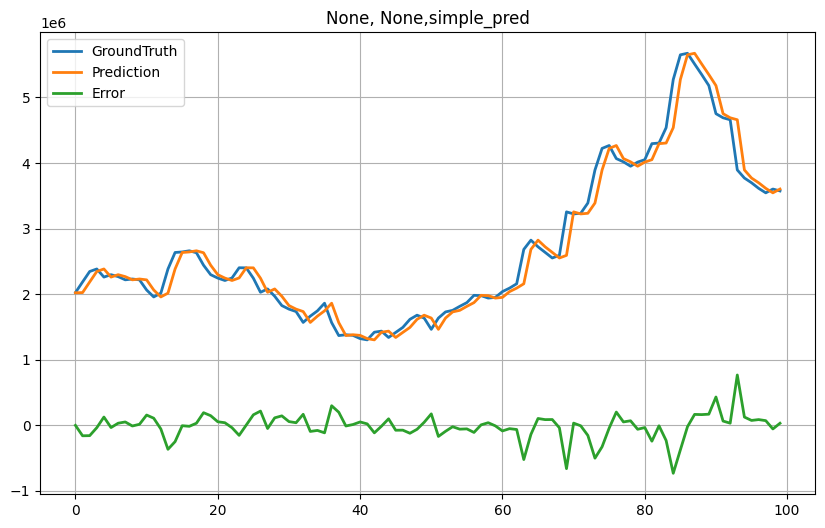

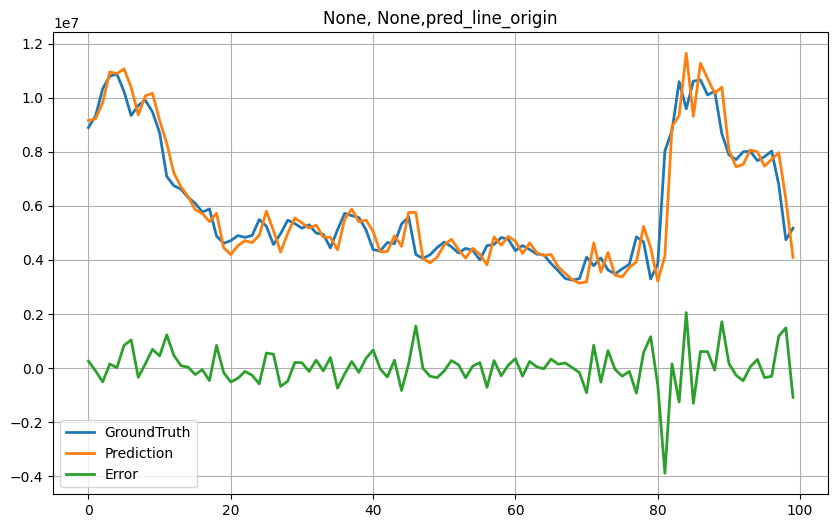

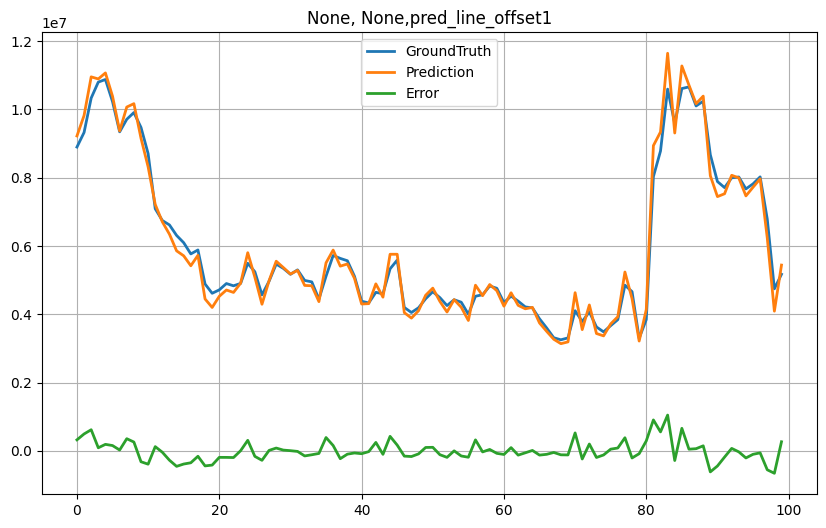

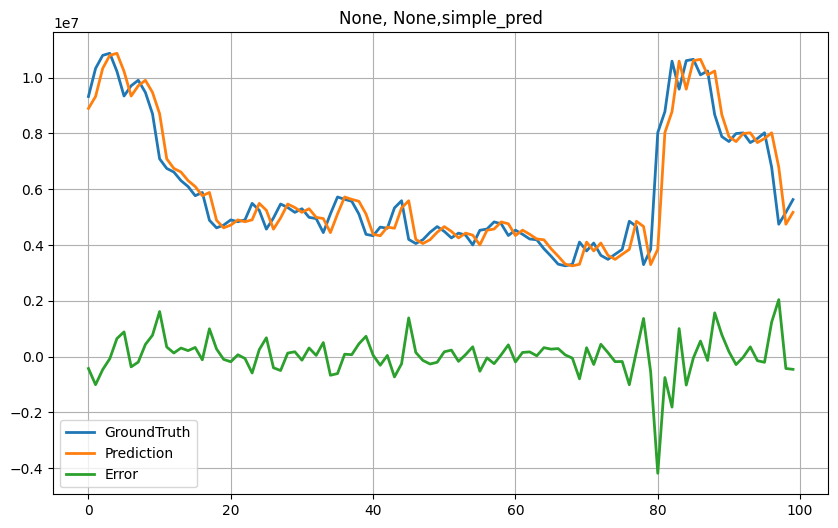

In [94]:
# 测试预测值, 预测值offset=1, 移动平均值, 朴素预测值的mse差距
fig, axs = plt.subplots(1, len(target_paths), figsize=(20, 6))
legend_elements = []
colors = ['b', 'g', 'r', 'c']
for index, path in enumerate(target_paths):
    true_line = np.load(f"{path}/true.npy")
    pred_line = np.load(f"{path}/pred.npy")
    # print(pred_line.__class__)
    print(true_line.shape)
    print(pred_line.shape)
    true_list = []
    pred_list = []
    label_list = []
    # lookback_field = extract_lookback(path)
    lookback_field = extract_lookback(path)
    pre_field = extract_pre(path)
    # pre_number = int(re.search(r'\d+', pre_field).group(0))
    pre_number = 1
    if lookback_field:
        title = f"Plot with lookback{lookback_field}, pre{pre_field}"
        match = re.search(r'\d+', lookback_field)
        if match:
            lookback_number = int(match.group(0))
            print("Extracted number:", lookback_number, pre_number)
    else:
        title = "Plot"
    print("before concate",true_line.shape)
    true_line = concat_data(true_line, range(0, true_line.shape[0], pre_number))
    print("after concate",true_line.shape)
    print(title)
    # print(lookback_number)
    print(range(0, pred_line.shape[0], pred_line.shape[1]))
    pred_line_origin = concat_data(pred_line, range(0, pred_line.shape[0], pre_number))#offset=0
    print("pred_line_origin shape:",pred_line_origin.shape)
    print("true_line shape:",true_line.shape)
    length = min(len(pred_line_origin), len(true_line))
    true_list.append(true_line[-length:])
    pred_list.append(pred_line_origin[-length:])
    label_list.append('pred_line_origin')
    # pred_line_offset1 = concat_data(pred_line, range(1, pred_line.shape[0], pre_number))#offset=1
    pred_line_offset1 = pred_line_origin[1:]
    # true_line_offset1 = concat_data(true_line, range(0, true_line.shape[0]-1, true_line.shape[1]))#offset=1
    true_line_offset1 = true_line[0:-1]
    true_list.append(true_line_offset1)
    pred_list.append(pred_line_offset1)
    label_list.append('pred_line_offset1')
    average_movement_pred = average_movement(true_line,3)#移动平均值
    length = min(len(average_movement_pred), len(true_line))
    true_list.append(true_line[-length+1:])
    pred_list.append(average_movement_pred[-length:-1])
    label_list.append('average_movement_pred')
    # simple_pred = concat_data(true_line, range(0, true_line.shape[0]-1, true_line.shape[1]))#朴素预测
    simple_pred = true_line[0:-1]
    true_list.append(true_line[1:])
    pred_list.append(simple_pred)
    label_list.append('simple_pred')
    title = f"{lookback_field}, {pre_field}"
    plot_loss(true_list,pred_list,label_list,loss,axs[index],title)
for i in range(4):
    color = colors[i % len(colors)]
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'{label_list[i]}'))
fig.legend(handles=legend_elements, loc='upper right')
fig.suptitle('Loss for Each Sample')
plt.show()
    


In [ ]:
import numpy as np

# 示例数据
data = np.array([1, 1,1,1,1,1,10,1,1,1,1,1,1])

# 定义移动平均的窗口大小
window_size = 3

# 创建一个窗口
window = np.ones(window_size) / window_size

# 使用卷积计算移动平均值
moving_average = np.convolve(data, window, mode='valid')

print("Original data:", data)
print("Moving average:", moving_average)
print(moving_average.__class__)

In [132]:
metrics = np.load(f"{target_paths[0]}/metrics.npy")
print(metrics)

[8.0625125e+05 1.9137335e+12 1.3833776e+06 9.1695145e-02 1.9055454e-02]


模型参数:
 const    0.094704
y.L1     0.985174
y.L2     0.112999
y.L3    -0.119933
y.L4    -0.070023
y.L5     0.072302
dtype: float64
预测值:
 100    5.970967
101    5.867189
102    5.835862
103    5.775479
104    5.754651
105    5.737622
106    5.720424
107    5.706018
108    5.689017
109    5.672389
dtype: float64


/home/antigone/miniconda3/envs/TSLib/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antigone/miniconda3/envs/TSLib/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antigone/miniconda3/envs/TSLib/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antigone/miniconda3/envs/TSLib/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antigone/miniconda3/envs/TSLib/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWar

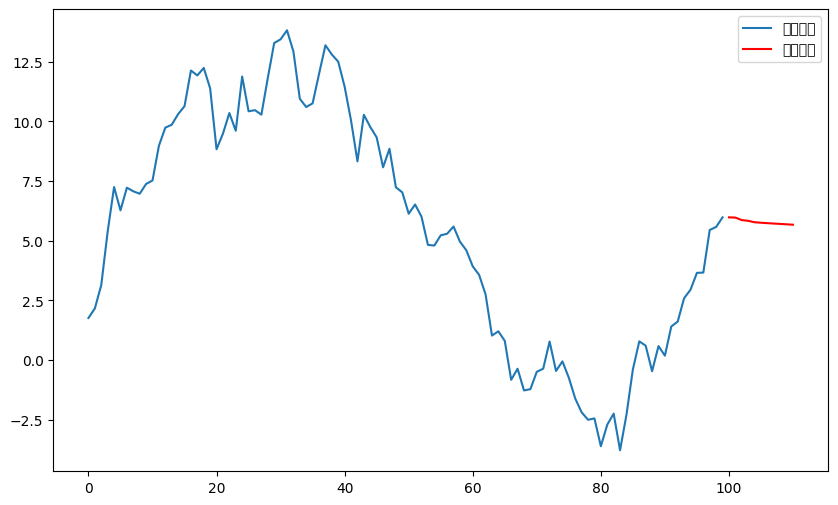

In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# 生成示例时间序列数据
np.random.seed(0)
data = np.random.randn(100)
data = pd.Series(data).cumsum()

# 拟合AR模型
model = AutoReg(data, lags=5)
model_fit = model.fit()

# 进行预测
forecast_steps = 10  # 预测未来10个时间点
predictions = model_fit.predict(start=len(data), end=len(data) + forecast_steps - 1)

# 返回值解释
print("模型参数:\n", model_fit.params)
print("预测值:\n", predictions)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(data, label='原始数据')
plt.plot(range(len(data), len(data) + forecast_steps+1), np.concatenate([data.values[-1:], predictions]), label='预测数据', color='red')
plt.legend()
plt.show()